# Implementing the Perceptron Algorithm
## Objective
To implement a Perceptron model for binary classification using the Iris dataset.

## Step 1: Understanding the Perceptron Algorithm
The Perceptron is a binary linear classifier that predicts labels based on a weighted sum of input features. If the prediction is incorrect, it updates the weights according to a learning rate and error in prediction.

### Formula
**Prediction**: $\hat{y} = \text{sign}(w \cdot x + b)$

**Update Rule**: $w_i = w_i + \eta \cdot (y - \hat{y}) \cdot x_i$

where:
- $w_i$: weight associated with feature $x_i$
- $\eta$: learning rate
- $y$: true label
- $\hat{y}$: predicted label

## Step 2: Dataset Preparation

### Dataset Loading
We use the Iris dataset, focusing on two-class, two-feature subsets for binary classification.

### Combinations
1. **Classes**: Two classes chosen at a time from the three unique classes in the dataset.
2. **Features**: Two features chosen at a time from the four available features.

### Data Preparation
For each selected class and feature pair:
1. Filter the data to include only the two chosen classes.
2. Label one class as `1` and the other as `-1`.
3. Standardize features (`mean = 0, variance = 1`).

This setup results in 18 subsets of data that we'll use to train and evaluate the Perceptron model.


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# Load the dataset, This dataset is stored on the Google Drive
data = pd.read_csv('./data/Iris.csv')
data = data[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']]

# Classes and features in the Iris dataset
classes = data['Species'].unique()
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Generate all 4C2 combinations of classes and features
class_combinations = list(combinations(classes, 2))
feature_combinations = list(combinations(features, 2))

# Store dataset subsets
data_subsets = []

# Loop through each class and feature combination and prepare dataset for each combination
for class_pair in class_combinations:
    for feature_pair in feature_combinations:
        subset = data[data['Species'].isin(class_pair)].copy()

        # Label encoding for binary classification: assign -1 and 1
        subset.loc[:, 'Label'] = subset['Species'].apply(lambda x: 1 if x == class_pair[0] else -1)
        subset = subset[list(feature_pair) + ['Label']]

        # Standardize the feature columns
        scaler = StandardScaler()
        subset.loc[:, list(feature_pair)] = scaler.fit_transform(subset[list(feature_pair)])
        data_subsets.append((class_pair, feature_pair, subset))

## Step 3: Data Preprocessing

### Verifying Data Subsets
To ensure our data is ready for training:
1. **Display Data Summary**: We print the first few rows of each subset to verify it contains only the selected classes and features.
2. **Confirm Standardization**: Each feature's mean should be close to 0 and variance close to 1 after standardization.

### Train-Test Split
Each subset is split into:
- **Training Set**: 80% of the data for training the Perceptron.
- **Testing Set**: 20% of the data for evaluating model performance.


In [2]:
from sklearn.model_selection import train_test_split

# Display summary of each data subset
for i, (class_pair, feature_pair, subset) in enumerate(data_subsets):
    print(f"\nSubset {i+1} - Classes: {class_pair}, Features: {feature_pair}")
    print(subset.head(), "\n")

    # Confirming standardization (mean close to 0, variance close to 1)
    print("Feature means:", subset[list(feature_pair)].mean())
    print("Feature variances:", subset[list(feature_pair)].var())

    # Split data into train and test sets
    X = subset[list(feature_pair)]
    Y = subset['Label']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Store the train-test split data for each subset
    data_subsets[i] = (class_pair, feature_pair, X_train, X_test, Y_train, Y_test)



Subset 1 - Classes: ('Iris-setosa', 'Iris-versicolor'), Features: ('SepalLengthCm', 'SepalWidthCm')
   SepalLengthCm  SepalWidthCm  Label
0      -0.581066      0.857135      1
1      -0.894309     -0.198450      1
2      -1.207552      0.223784      1
3      -1.364174      0.012667      1
4      -0.737687      1.068253      1 

Feature means: SepalLengthCm   -1.518230e-15
SepalWidthCm     2.886580e-16
dtype: float64
Feature variances: SepalLengthCm    1.010101
SepalWidthCm     1.010101
dtype: float64

Subset 2 - Classes: ('Iris-setosa', 'Iris-versicolor'), Features: ('SepalLengthCm', 'PetalLengthCm')
   SepalLengthCm  PetalLengthCm  Label
0      -0.581066      -1.014360      1
1      -0.894309      -1.014360      1
2      -1.207552      -1.083741      1
3      -1.364174      -0.944978      1
4      -0.737687      -1.014360      1 

Feature means: SepalLengthCm   -1.518230e-15
PetalLengthCm   -3.863576e-16
dtype: float64
Feature variances: SepalLengthCm    1.010101
PetalLengthCm    1.0

## Step 4: Implementing the Perceptron Model

### 1. Initialization (`_init_` Method)
- **Parameters**: `learning_rate`, `epochs`, and `random_state` (for reproducibility).
- **Weights**: Initialized randomly for each feature.
- **Bias**: Set to zero initially.

### 2. Training (`fit` Method)
- **Update Rule**:
  - If a misclassification occurs, weights and bias are updated using: $w_i = w_i + \eta \cdot (y - \hat{y}) \cdot x_i$

- **Accuracy Tracking**:
  - Accuracy is calculated at each epoch to track learning progress and evaluate model convergence.

### 3. Prediction (`predict` Method)
- The model calculates the weighted sum of features and applies the step function to output a predicted class, either -1 or 1.


In [3]:
import numpy as np

class Perceptron:
    def __init__(self, learning_rate=0.01, epochs=1000, random_state=42):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.weights = None
        self.bias = None

    def fit(self, X, Y):
        # Initialize weights and bias
        np.random.seed(self.random_state)
        self.weights = np.random.rand(X.shape[1])
        self.bias = 0
        self.epoch_accuracies = []

        # Training loop
        for epoch in range(self.epochs):
            correct_predictions = 0
            for xi, target in zip(X.values, Y):
                # Calculate the linear output
                linear_output = np.dot(xi, self.weights) + self.bias
                y_pred = 1 if linear_output >= 0 else -1

                # Check if prediction matches target
                if y_pred == target:
                    correct_predictions += 1

                # Update weights and bias if prediction is incorrect
                self.weights += self.learning_rate * (target - y_pred) * xi
                self.bias += self.learning_rate * (target - y_pred)

            # Calculate accuracy for the epoch
            accuracy = correct_predictions / len(Y)
            self.epoch_accuracies.append(accuracy)

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, -1)


## Step 5: Training the Model on Each Subset

### Training Process
For each 4C2 combination of classes and features, we:
1. **Initialize the Perceptron Model**: With a specified learning rate and number of epochs.
2. **Train the Model**: Using the training data for each subset.
3. **Track Final Accuracy**: Store the accuracy at the last epoch for each model.

### Results Storage
- The training results, including the model and final training accuracy for each subset, are stored in a dictionary.
- These results will be used for evaluation on the test data in the next steps.

In [4]:
# List to store training accuracies
training_accuracies = []

# Dictionary to store training results
training_results = {}

for i, (class_pair, feature_pair, X_train, X_test, Y_train, Y_test) in enumerate(data_subsets):
    # Initialize the Perceptron model
    perceptron = Perceptron(learning_rate=0.001, epochs=30, random_state=42)
    perceptron.fit(X_train, Y_train)

    train_predictions = perceptron.predict(X_train)
    train_accuracy = np.mean(train_predictions == Y_train)
    training_accuracies.append(train_accuracy)

    # Store the model and training accuracy
    training_results[(class_pair, feature_pair)] = {
        "model": perceptron,
        "train_accuracy": train_accuracy
    }

    print(f"Final Training Accuracy for Subset {i+1}: {train_accuracy:.2f}")

Final Training Accuracy for Subset 1: 0.97
Final Training Accuracy for Subset 2: 1.00
Final Training Accuracy for Subset 3: 1.00
Final Training Accuracy for Subset 4: 0.97
Final Training Accuracy for Subset 5: 0.97
Final Training Accuracy for Subset 6: 0.99
Final Training Accuracy for Subset 7: 0.97
Final Training Accuracy for Subset 8: 0.99
Final Training Accuracy for Subset 9: 0.99
Final Training Accuracy for Subset 10: 0.99
Final Training Accuracy for Subset 11: 0.99
Final Training Accuracy for Subset 12: 1.00
Final Training Accuracy for Subset 13: 0.53
Final Training Accuracy for Subset 14: 0.96
Final Training Accuracy for Subset 15: 0.93
Final Training Accuracy for Subset 16: 0.96
Final Training Accuracy for Subset 17: 0.94
Final Training Accuracy for Subset 18: 0.95


## Step 6: Model Evaluation on Test Data

### Evaluation Process
For each model trained on a 4C2 combination of classes and features, we:
1. **Make Predictions**: Use the Perceptron model to classify the test set.
2. **Calculate Accuracy**: Compare predictions with the true labels to calculate accuracy.

### Results Storage
- The test accuracy for each subset is stored in the `training_results` dictionary, along with the training accuracy and trained model.
- These results will provide insights into the model's generalization performance for different class-feature combinations.

In [5]:
# List to store testing accuracies
testing_accuracies = []

# Add test results to the training_results dictionary
for (class_pair, feature_pair), result in training_results.items():
    perceptron = result["model"]
    for data in data_subsets:
        if data[0] == class_pair and data[1] == feature_pair:
            X_test = data[3]
            Y_test = data[5]
            break
    else:
        print(f"No data found for {class_pair} and {feature_pair}")
        continue

    # Predict on test set and calculate accuracy
    y_pred = perceptron.predict(X_test.values)
    test_accuracy = np.mean(y_pred == Y_test)
    testing_accuracies.append(test_accuracy)
    training_results[(class_pair, feature_pair)]["test_accuracy"] = test_accuracy
    print(f"Test Accuracy for Classes {class_pair}, Features {feature_pair}: {test_accuracy:.2f}")

Test Accuracy for Classes ('Iris-setosa', 'Iris-versicolor'), Features ('SepalLengthCm', 'SepalWidthCm'): 0.95
Test Accuracy for Classes ('Iris-setosa', 'Iris-versicolor'), Features ('SepalLengthCm', 'PetalLengthCm'): 0.95
Test Accuracy for Classes ('Iris-setosa', 'Iris-versicolor'), Features ('SepalLengthCm', 'PetalWidthCm'): 1.00
Test Accuracy for Classes ('Iris-setosa', 'Iris-versicolor'), Features ('SepalWidthCm', 'PetalLengthCm'): 1.00
Test Accuracy for Classes ('Iris-setosa', 'Iris-versicolor'), Features ('SepalWidthCm', 'PetalWidthCm'): 1.00
Test Accuracy for Classes ('Iris-setosa', 'Iris-versicolor'), Features ('PetalLengthCm', 'PetalWidthCm'): 1.00
Test Accuracy for Classes ('Iris-setosa', 'Iris-virginica'), Features ('SepalLengthCm', 'SepalWidthCm'): 1.00
Test Accuracy for Classes ('Iris-setosa', 'Iris-virginica'), Features ('SepalLengthCm', 'PetalLengthCm'): 1.00
Test Accuracy for Classes ('Iris-setosa', 'Iris-virginica'), Features ('SepalLengthCm', 'PetalWidthCm'): 1.00
Tes

## Step 7: Visualization of Perceptron Model Performance

### Visualization Types
1. **Decision Boundary Plot**: For each model trained on a different subset of classes and features:
   - **Decision Boundary**: Shows the dividing line created by the Perceptron to separate classes.
   - **Data Points**: Training and testing data points are plotted with different colors for each class.

2. **Accuracy Over Epochs Plot**: For each subset, a plot of training accuracy over epochs displays how quickly the model converges.

### Insights
- **Decision Boundary**: Helps to understand how the Perceptron model learns to classify the classes based on feature pairs.
- **Training Accuracy Over Epochs**: Provides insights into model stability and convergence rate with the chosen learning rate and epochs.


In [6]:
# Calculate mean accuracies
mean_training_accuracy = np.mean(training_accuracies)
mean_testing_accuracy = np.mean(testing_accuracies)

# Print mean accuracies
print(f"Mean Training Accuracy across all combinations: {mean_training_accuracy:.2f}")
print(f"Mean Testing Accuracy across all combinations: {mean_testing_accuracy:.2f}")


Mean Training Accuracy across all combinations: 0.95
Mean Testing Accuracy across all combinations: 0.93


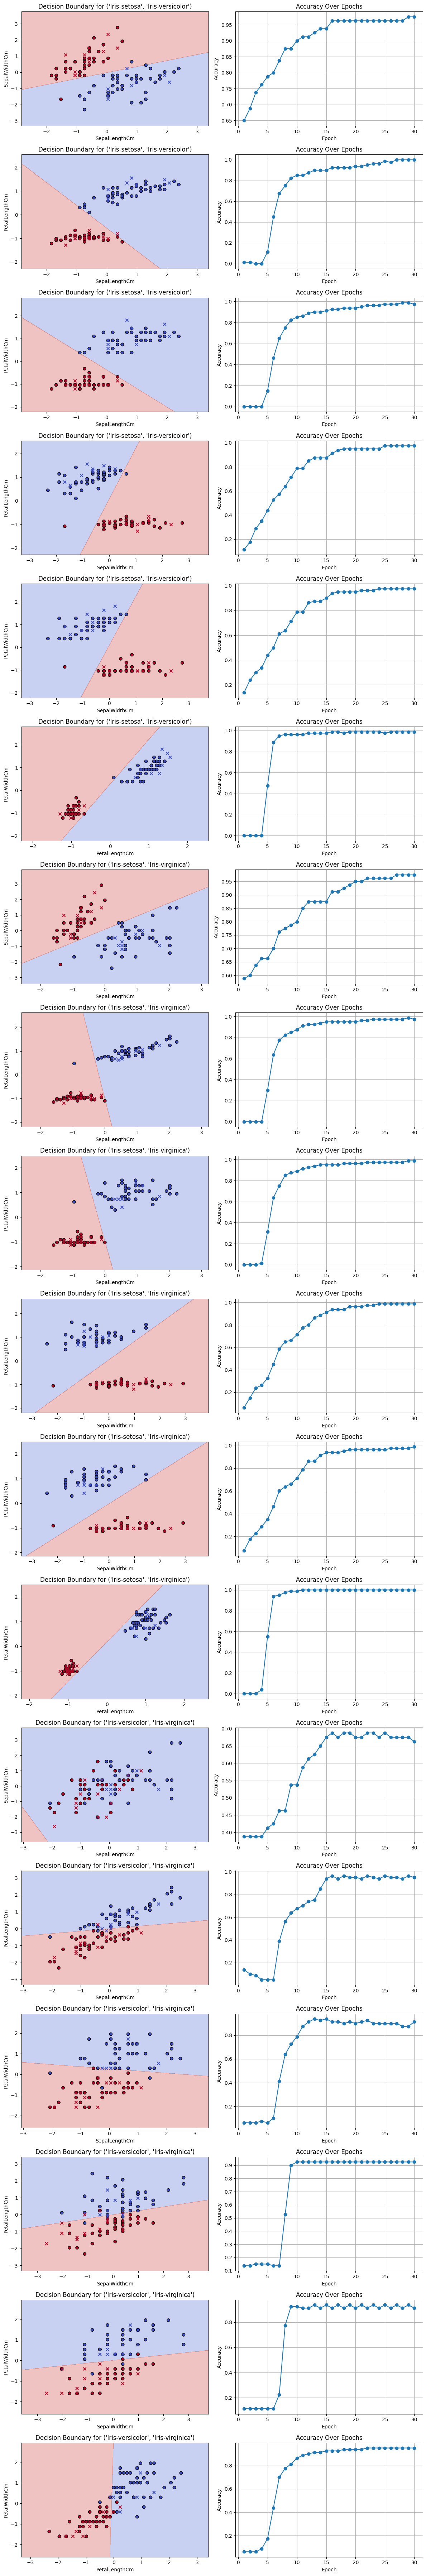

In [7]:
import matplotlib.pyplot as plt
import numpy as np

rows = len(training_results.items())
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
plot_index = 0

# Generate plots for each combination of classes and features
for (class_pair, feature_pair), result in training_results.items():
    perceptron = result["model"]
    for data in data_subsets:
        if data[0] == class_pair and data[1] == feature_pair:
            X_train = data[2]
            Y_train = data[4]
            X_test = data[3]
            Y_test = data[5]
            break
    else:
        print(f"No data found for {class_pair} and {feature_pair}")
        continue

    perceptron.fit(X_train, Y_train)
    X_combined = np.vstack([X_train, X_test])
    y_combined = np.hstack([Y_train, Y_test])
    x_min, x_max = X_combined[:, 0].min() - 1, X_combined[:, 0].max() + 1
    y_min, y_max = X_combined[:, 1].min() - 1, X_combined[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot Decision Boundary
    axes[plot_index, 0].contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    axes[plot_index, 0].scatter(
        X_train.iloc[:, 0],
        X_train.iloc[:, 1],
        edgecolors="k",
        cmap="coolwarm",
        c=Y_train,
        marker="o",
        label="Training Data",
    )
    axes[plot_index, 0].scatter(
        X_test.iloc[:, 0],
        X_test.iloc[:, 1],
        cmap="coolwarm",
        c=Y_test,
        marker="x",
        label="Test Data",
    )
    axes[plot_index, 0].set_title(f'Decision Boundary for {class_pair}')
    axes[plot_index, 0].set_xlabel(feature_pair[0])
    axes[plot_index, 0].set_ylabel(feature_pair[1])

    # Plot accuracy over epochs
    axes[plot_index, 1].set_title("Accuracy Over Epochs")
    axes[plot_index, 1].plot(
        range(1, len(perceptron.epoch_accuracies) + 1),
        perceptron.epoch_accuracies,
        marker="o",
    )
    axes[plot_index, 1].set_xlabel("Epoch")
    axes[plot_index, 1].set_ylabel("Accuracy")
    axes[plot_index, 1].grid()
    plot_index += 1

plt.tight_layout()
plt.show()

# Analysis and Reporting

## 1. Perceptron Algorithm Overview
The Perceptron algorithm is a foundational linear classifier that uses a simple yet effective weight update mechanism to classify data. In each epoch, weights are adjusted using the formula:  
$$
w_i = w_i + \eta \cdot (y - \hat{y}) \cdot x_i
$$
This allows the model to gradually learn a decision boundary that separates the classes.

## 2. Implementation Summary
Our implementation included:
- **Data Preparation**: Selected various combinations of class pairs and feature pairs from the Iris dataset.
- **Model Training**: Initialized and trained a Perceptron model for each combination, recording accuracy over epochs.
- **Evaluation**: Each model was tested on a hold-out test set to determine its accuracy on unseen data.

## 3. Observations on Decision Boundaries
- The decision boundary for each model illustrates how the Perceptron classifies classes based on different feature pairs.
- Certain class pairs, like Setosa vs. Versicolor, demonstrated clear linear separability, while others were more challenging.

## 4. Accuracy Over Epochs
- Training accuracy generally increased with epochs, stabilizing as the model converged.
- Models with more separable data reached higher accuracy faster than those with overlapping class distributions.

## 5. Impact of HyperParameters
- **Learning Rate**: Lower learning rates required more epochs for convergence but provided smoother accuracy progression.
- **Epochs**: Increasing the number of epochs generally improved accuracy but plateaued once the model converged.

## 6. Challenges and Limitations
The Perceptron algorithm is limited in its ability to classify data that is not linearly separable. In future work, incorporating a non-linear classifier, such as the multi-layer Perceptron, could address this limitation.